### Clearing "scanned" ink stamp using autoencoder with Keras and TensorFlow

In this notebook I am practicing using autoencoder. As an example, I emulate a part of scanned document and then clear the ink stamp from unwanted "scanned" text.<br>

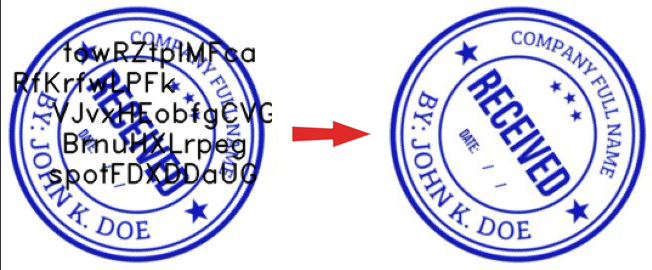


Special thanks to [**Adrian Rosebrock**](https://pyimagesearch.com/author/adrian/) from pyimagesearch.com for his excellent [**tutorial**](https://pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/) !

In [1]:
!pip install imutils
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
import string
import random

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.data import AUTOTUNE

  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=57f3aa141050bfe57a153fe0b3fdb62b6adcf24ac3bbe66adf18c6fe141ec6bd
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


This is a helper function to show images

In [2]:
def show(image,H = 10, W = 10):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (H, W))
    plt.xticks([]), plt.yticks([])
    if len(image.shape) == 2:
        plt.imshow(image, cmap = 'gray')
    else:
        plt.imshow(image)
    plt.show()

Here is a sample ink stamp image I will use for training data generation

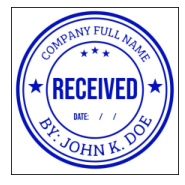

In [3]:
stamp_raw = cv2.imread('../input/stamp-data/stamp.jpg')
SIZE = 224
stamp_raw =  imutils.resize(stamp_raw, width = SIZE, height = SIZE)
show(stamp_raw, H=3)

Using this function I generate training data randomly distorting the image. I'm applaying:<br>
-random stamp rotation<br>
-random text addition (one line)<br>
<br>
Then I invert colors and scale to 0..1 range<br>

*Color inversion has two meanings. First, it gets rid of the dark corners when you rotate the original picture. Secondly I have to feed white on black (or color on black) images to the neural network anyway.*

In [4]:
stamp = 255 - stamp_raw
letters = string.ascii_letters

def gen_img(lines = 1):
    ang = np.random.randint(359)
    clean = imutils.rotate(stamp, ang)
    dirty = clean.copy()
    
    pos_Y = np.random.randint(0, stamp_raw.shape[1] - 25 * lines)
    
    for i in range(lines):
        letters_num = np.random.randint(10, 15)
        pos_X = np.random.randint(0, stamp_raw.shape[0] // 4 )
    
        text = ''.join(random.choice(letters) for i in range(letters_num))
        cv2.putText(dirty,
                    text,
                    org=(pos_X, pos_Y + 25 * i),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX,
                    fontScale=0.75,
                    color=(255, 255, 255),
                    thickness=1,
                    lineType = cv2.LINE_AA)
        
    dirty = dirty.astype('float32') / 255
    clean = clean.astype('float32') / 255
        
    return dirty, clean

Here are the sample pair of images in inversed and in normal colors:

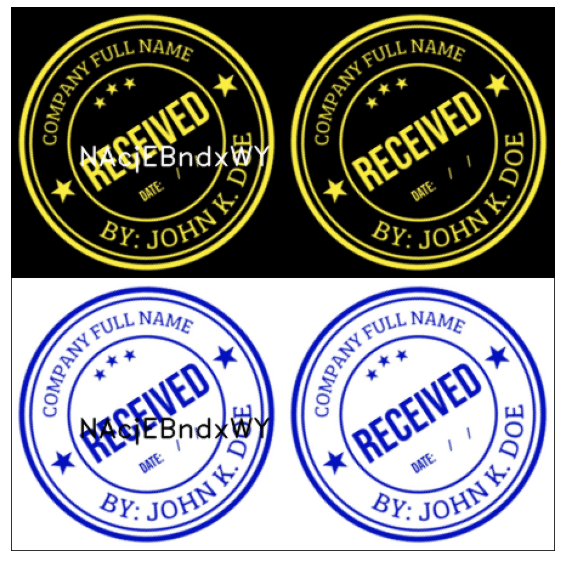

In [5]:
a, b = gen_img()
inversed = np.hstack((a, b))
normal = np.hstack((1 - a, 1 - b))
show(np.vstack((inversed, normal)))

As soon as I have the generation function I can generate any number of samples. I decided to do as in MNIST dataset: 50K for training and 10K for validation. With such number of samples ten epochs would be enough to get an acceptable result.

In [6]:
TRAIN_SIZE = 50000
VALID_SIZE = 10000
BS = 32
EPOCHS = 10

In order to sped up the training I will use TensofFlow ```tf.data.Dataset.from_generator``` method. You can get more details in TensorFlow [**manual](https://www.tensorflow.org/guide/data).
<br>First I create two generators for trainig and for validation:

In [7]:
def call_func():
    x, y = gen_img()
    return x, y

train_gen = (call_func() for i in range(TRAIN_SIZE * EPOCHS))
valid_gen = (call_func() for i in range(VALID_SIZE * EPOCHS))

Then I call these generators by ```tf.data.Dataset.from_generator```<br>
Despite of the fact that I actually use the same generator for training and validation both, TensorFlow needs **seperate** generators for training and for validation

In [8]:
train = tf.data.Dataset.from_generator(
    lambda: train_gen, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([SIZE,SIZE,3], [SIZE,SIZE,3]))

valid = tf.data.Dataset.from_generator(
    lambda: valid_gen, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([SIZE,SIZE,3], [SIZE,SIZE,3]))


train = train.batch(BS).repeat().prefetch(AUTOTUNE)
valid = valid.batch(BS).repeat().prefetch(AUTOTUNE)

2022-03-19 11:45:07.582361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 11:45:07.708286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 11:45:07.709485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 11:45:07.712509: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

#### Autoencoder model defenition

In [9]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=16):
        inputShape = (height, width, depth)
        chanDim = -1

        inputs = Input(shape=inputShape)
        x = inputs

        for f in filters:
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)

        encoder = Model(inputs, latent, name="encoder")

        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

        for f in filters[::-1]:
            x = Conv2DTranspose(f, (3, 3), strides=2,
                padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)

        decoder = Model(latentInputs, outputs, name="decoder")

        autoencoder = Model(inputs, decoder(encoder(inputs)),
            name="autoencoder")

        return (encoder, decoder, autoencoder)

#### Model building

In [10]:
(encoder, decoder, autoencoder) = ConvAutoencoder.build(SIZE, SIZE, 3)
opt = Adam(learning_rate=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)
encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        256 

#### Model training

In [11]:
%%time
H = autoencoder.fit(
    train,
    validation_data = valid,
    epochs=EPOCHS,
    steps_per_epoch = TRAIN_SIZE // BS,
    validation_steps = VALID_SIZE // BS)

2022-03-19 11:45:11.391531: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-03-19 11:45:13.337636: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1562/1562 [==============================] - 154s 94ms/step - loss: 0.0132 - val_loss: 0.0050
Epoch 2/10
1562/1562 [==============================] - 147s 94ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 3/10
1562/1562 [==============================] - 150s 96ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 4/10
1562/1562 [==============================] - 145s 93ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 5/10
1562/1562 [==============================] - 147s 94ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/10
1562/1562 [==============================] - 147s 94ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/10
1562/1562 [==============================] - 148s 95ms/step - loss: 0.0010 - val_loss: 7.9249e-04
Epoch 8/10
1562/1562 [==============================] - 144s 92ms/step - loss: 7.0236e-04 - val_loss: 6.9389e-04
Epoch 9/10
1562/1562 [==============================] - 146s 93ms/step - loss: 6.4771e-04 - val_loss: 6.7690e-04
Epoch 10/10
1562/1562 [=======================

#### Model serialization

In [12]:
autoencoder.save('trained_stamp_model.h5')

#### Losses

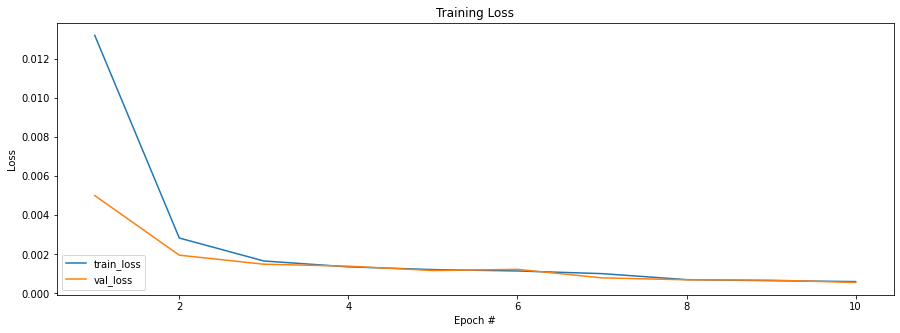

In [13]:
N = range(1,EPOCHS+1)
plt.figure(figsize = (15,5))
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

#### Results
Please note that I used training pictures with just one line of text, but as you can see the model works properly with many lines of text as well.

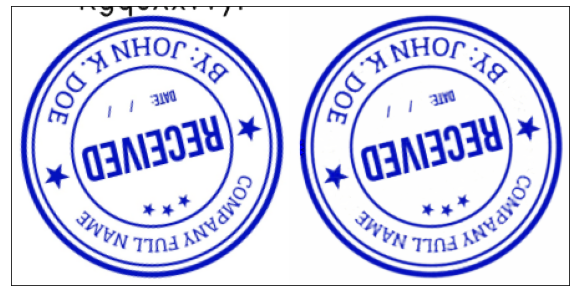

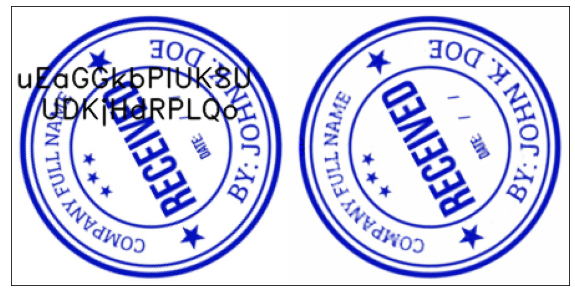

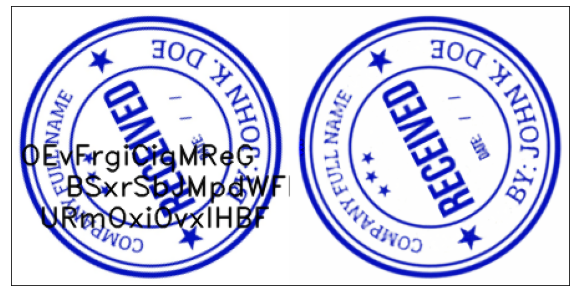

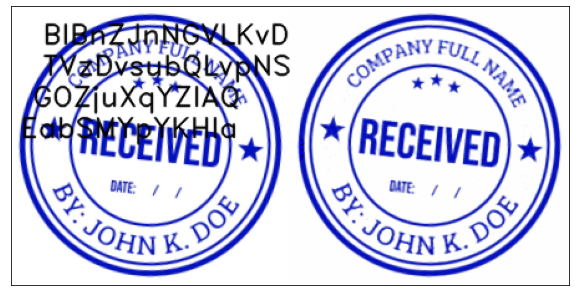

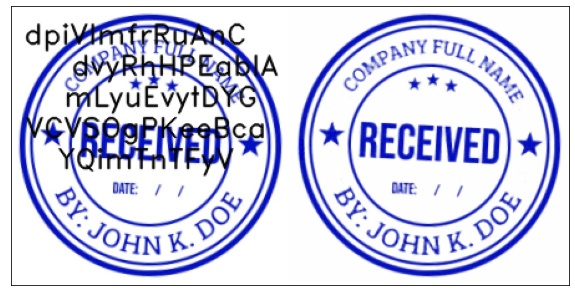

In [14]:
for i in range(1,6):
    test, _ = gen_img(i)
    test = np.expand_dims(test, 0)
    pred = autoencoder.predict(test)
    show(np.hstack((1-test[0],1-pred[0])), H=10)

#### Thank you for your attention !